## Applying Space-Filling Curves for Data Science with Time-Series Data on the Example of Automotive Data

Event detection is essential for various application domains. In this example, we focus on the automotive domain. We will use space-filling curves (SFCs) to reduce data dimensionality of the original data space to analyze time-series data. Next, we will work on the compactified, single-dimensional data space to identify patterns that correlate with patterns in the multi-dimensional data space and hence, can be interpreted as events.

### 1. Introducing Space-Filling Curve Computations

First, we use an external library to compute single dimensional representations from multi-dimensional data called [zCurve](https://github.com/rmrschub/zCurve). The library can be used as follows:

In [91]:
import zCurve as z

# Combine the 3D point (2, 16, 8) into a Morton code.
morton_code = z.interlace(2, 16, 8)
assert morton_code == 10248, "morton_code should be 10248"
print( morton_code )

10248


Next, we focus on two-dimensional data as found in GPS positions. Please note that we have transformed floating point GPS positions to positive integers as SFCs typically operate on positive input values.

In [92]:
import zCurve as z

morton_code1 = z.interlace(57772400, 12765000, dims=2)
assert morton_code1 == 1606428908008832, "morton_code1 should be 1606428908008832"

morton_code2 = z.interlace(57773800, 12772000, dims=2)
assert morton_code2 == 1606429041286208, "morton_code2 should be 1606429041286208"

print( str(morton_code1) + "\n" + str(morton_code2) )

1606428908008832
1606429041286208


Next, we add a function to turn floating point numbers into positive integers using a dedicated function. The expected values originate from the [corresponding C implementation](https://github.com/chrberger/cluon-cabinet/blob/ZEBRA/test/tests-morton.cpp#L46-L84).

In [93]:
import zCurve as z

def calculateMortonFromTwoLatLonFloats_with_zCurve(x, y):
    # Cap floating point numbers to six decimal places.
    x_int = int( round( (x + 90.0), 5 ) * 100000 )
    y_int = int( round( (y + 180.0), 5 ) * 100000 )
    value = z.interlace(x_int, y_int, dims=2)
    return value

morton_code1_f = calculateMortonFromTwoLatLonFloats_with_zCurve(60.734398, 14.768745)
assert morton_code1_f == 664749436224648, "morton_code1_f should be 664749436224648"
print( "Two positive floats: " + str(morton_code1_f) )

morton_code2_f = calculateMortonFromTwoLatLonFloats_with_zCurve(38.969745, -77.201958)
assert morton_code2_f == 231657429695220, "morton_code2_f should be 231657429695220"
print( "One positive/one negative float: " + str(morton_code2_f) )

morton_code3_f = calculateMortonFromTwoLatLonFloats_with_zCurve(-34.619055, -58.364067)
assert morton_code3_f == 171054631290070, "morton_code3_f should be 171054631290070"
print( "Two negative floats: " + str(morton_code3_f) )

morton_code4_f = calculateMortonFromTwoLatLonFloats_with_zCurve(-33.956603, 150.949719)
assert morton_code4_f == 769185334910896, "morton_code4_f should be 769185334910896"
print( "One negative/one positive float floats: " + str(morton_code4_f) )

Two positive floats: 664749436224648
One positive/one negative float: 231657429695220
Two negative floats: 171054631290070
One negative/one positive float floats: 769185334910896


As we want identical results on Python and C++, we supply an own implementation to calculate Morton codes from two-dimensional values. The corresponding C++ implementation can be found [here](https://github.com/chrberger/cluon-cabinet/blob/ZEBRA/src/morton.hpp#L41-L74) and the original source [here (CC BY-SA 4.0)](https://stackoverflow.com/a/30562230). Now, it is important that we are precise about the underlying dataypes and hence, we are using NumPy.

In [94]:
import numpy as np

def mortonEncode2D(a, b):
    x = np.uint64(a)
    y = np.uint64(b)

    x = (x | (x << np.uint64(16))) & np.uint64(0x0000FFFF0000FFFF)
    x = (x | (x << np.uint64(8)))  & np.uint64(0x00FF00FF00FF00FF)
    x = (x | (x << np.uint64(4)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    x = (x | (x << np.uint64(2)))  & np.uint64(0x3333333333333333)
    x = (x | (x << np.uint64(1)))  & np.uint64(0x5555555555555555)

    y = (y | (y << np.uint64(16))) & np.uint64(0x0000FFFF0000FFFF)
    y = (y | (y << np.uint64(8)))  & np.uint64(0x00FF00FF00FF00FF)
    y = (y | (y << np.uint64(4)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    y = (y | (y << np.uint64(2)))  & np.uint64(0x3333333333333333)
    y = (y | (y << np.uint64(1)))  & np.uint64(0x5555555555555555)

    result = np.uint64( x | (y << np.uint64(1)) )
    return result

def mortonExtractEvenBits(a):
    x = np.uint64(a)
    
    x = x & np.uint64(0x5555555555555555)
    x = (x | (x >> np.uint64(1)))  & np.uint64(0x3333333333333333)
    x = (x | (x >> np.uint64(2)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    x = (x | (x >> np.uint64(4)))  & np.uint64(0x00FF00FF00FF00FF)
    x = (x | (x >> np.uint64(8)))  & np.uint64(0x0000FFFF0000FFFF)
    x = (x | (x >> np.uint64(16))) & np.uint64(0x00000000FFFFFFFF)
    
    return x.astype(np.uint32)

def mortonDecode2D(a):
    _a = np.uint64(a)
    
    x = mortonExtractEvenBits(_a)
    y = mortonExtractEvenBits(_a >> np.uint64(1))
    
    return (x, y)

morton_code1 = mortonEncode2D(57772400, 12765000)
assert morton_code1 == 1606428908008832, "morton_code1 should be 1606428908008832"
print( morton_code1 )

decode_morton_code1 = mortonDecode2D(1606428908008832)
assert decode_morton_code1 == (57772400, 12765000), "decode_morton_code1 should be (57772400, 12765000)"
print( decode_morton_code1 )

1606428908008832
(57772400, 12765000)


Finally, we can compare the two implementations.

In [95]:
morton_code1_3rd = z.interlace(57772400, 12765000, dims=2)
morton_code1_own = mortonEncode2D(57772400, 12765000)

print( morton_code1_3rd - morton_code1_own )

0.0


Now, we are putting the pieces together.

In [96]:
def calculateMortonFromTwoLatLonFloats(x, y):
    _x = np.float32(x)
    _y = np.float32(y)
    # Cap floating point numbers to six decimal places.
    x_int = np.uint32( np.round( (_x + np.float32(90.0) ), 6 ) * np.uint32(100000) )
    y_int = np.uint32( np.round( (_y + np.float32(180.0) ), 6 ) * np.uint32(100000) )
    value = mortonEncode2D(x_int, y_int)
    return value

p1 = (60.734398, 14.768745)
morton_code1 = calculateMortonFromTwoLatLonFloats(p1[0], p1[1])
assert morton_code1 == 664749436224642, "morton_code1 should be 664749436224642"
print( "Two positive floats: " + str(morton_code1) )
print( "Delta to 3rd party library: " + str(morton_code1 - morton_code1_f) )

p2 = (38.969745, -77.201958)
morton_code2 = calculateMortonFromTwoLatLonFloats(p2[0], p2[1])
assert morton_code2 == 231657429695220, "morton_code2 should be 231657429695220"
print( "One positive/one negative float: " + str(morton_code2) )
print( "Delta to 3rd party library: " + str(morton_code2 - morton_code2_f) )

p3 = (-34.619055, -58.364067)
morton_code3 = calculateMortonFromTwoLatLonFloats(p3[0], p3[1])
assert morton_code3 == 171054631290070, "morton_code3 should be 171054631290070"
print( "Two negative floats: " + str(morton_code3) )
print( "Delta to 3rd party library: " + str(morton_code3 - morton_code3_f) )

p4 = (-33.956603, 150.949719)
morton_code4 = calculateMortonFromTwoLatLonFloats(p4[0], p4[1])
assert morton_code4 == 769185334910861, "morton_code4 should be 769185334910861"
print( "One negative/one positive float floats: " + str(morton_code4) )
print( "Delta to 3rd party library: " + str(morton_code4 - morton_code4_f) )

Two positive floats: 664749436224642
Delta to 3rd party library: -6.0
One positive/one negative float: 231657429695220
Delta to 3rd party library: 0.0
Two negative floats: 171054631290070
Delta to 3rd party library: 0.0
One negative/one positive float floats: 769185334910861
Delta to 3rd party library: -35.0


Finally, we convert the Morton code back into two floating point numbers.

In [97]:
import sys

def calculateTwoLatLonFloatsFromMorton(a):
    pair = mortonDecode2D(a)
    _x = np.float32(pair[0] / np.float32(100000.0) - np.float32(90.0))
    _y = np.float32(pair[1] / np.float32(100000.0) - np.float32(180.0))
    return (_x, _y)

eps = 0.00001
decode_morton_code1 = calculateTwoLatLonFloatsFromMorton(morton_code1)
print( "{:.6f}".format(decode_morton_code1[0]) + " " + "{:.6f}".format(decode_morton_code1[1]))
print( "Delta: " + "{:.6f}".format(decode_morton_code1[0] - p1[0]) + " " + "{:.6f}".format(decode_morton_code1[1] - p1[1]))
assert np.fabs(decode_morton_code1[0] - p1[0]) < eps , "Delta for p1 after decoding too large"

decode_morton_code2 = calculateTwoLatLonFloatsFromMorton(morton_code2)
print( "{:.6f}".format(decode_morton_code2[0]) + " " + "{:.6f}".format(decode_morton_code2[1]))
print( "Delta: " + "{:.6f}".format(decode_morton_code2[0] - p2[0]) + " " + "{:.6f}".format(decode_morton_code2[1] - p2[1]))
assert np.fabs(decode_morton_code2[0] - p2[0]) < eps , "Delta for p2 after decoding too large"

decode_morton_code3 = calculateTwoLatLonFloatsFromMorton(morton_code3)
print( "{:.6f}".format(decode_morton_code3[0]) + " " + "{:.6f}".format(decode_morton_code3[1]))
print( "Delta: " + "{:.6f}".format(decode_morton_code3[0] - p3[0]) + " " + "{:.6f}".format(decode_morton_code3[1] - p3[1]))
assert np.fabs(decode_morton_code3[0] - p3[0]) < eps , "Delta for p3 after decoding too large"

decode_morton_code4 = calculateTwoLatLonFloatsFromMorton(morton_code4)
print( "{:.6f}".format(decode_morton_code4[0]) + " " + "{:.6f}".format(decode_morton_code4[1]))
print( "Delta: " + "{:.6f}".format(decode_morton_code4[0] - p4[0]) + " " + "{:.6f}".format(decode_morton_code4[1] - p4[1]))
assert np.fabs(decode_morton_code4[0] - p4[0]) < eps , "Delta for p4 after decoding too large"

60.734402 14.768730
Delta: 0.000004 -0.000015
38.969742 -77.201958
Delta: -0.000003 0.000000
-34.619061 -58.364071
Delta: -0.000006 -0.000004
-33.956612 150.949707
Delta: -0.000009 -0.000012


### 2. Processing Multi-Dimensional Automotive Data

Now, we have seen how to compute Morton codes from two-dimensional, floating point data including potential rounding errors that are introduced by the conversion.
In this section, we will look into how to correlate Morton codes from time-series data to a maneuver in the multi-dimensional data space. For our experiments, we will use a dataset that contains an emergency braking maneuver.
First, we analyze how the data is organized and we see that we have columns such as `lat`, `lon`, and `speed`. As a first step, we simply plot the position of the vehicle using its speed information to color its position in the scatter plot.

Column headers: ['sampleTimeStamp.seconds', 'sampleTimeStamp.microseconds', 'lat', 'lon', 'speed', 'accel_x', 'accel_y', 'accel_z']


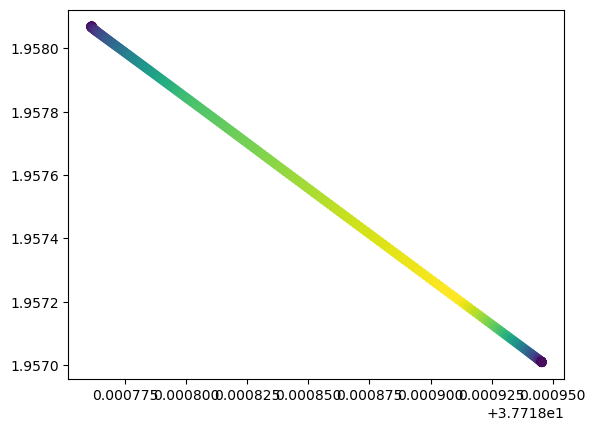

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# First, we read the CSV file.
df = pd.read_csv('emergency_braking.csv', sep=';')

# Next, we print the column headers to know what we have access to.
cols = df.columns.values.tolist()
print( "Column headers: " + str(cols) )

# Plot the position of the vehicle using its speed to color.
plt.scatter(df['lat'], df['lon'], c=df['speed'])
plt.show()

Next, we plot the various accelerations over time.

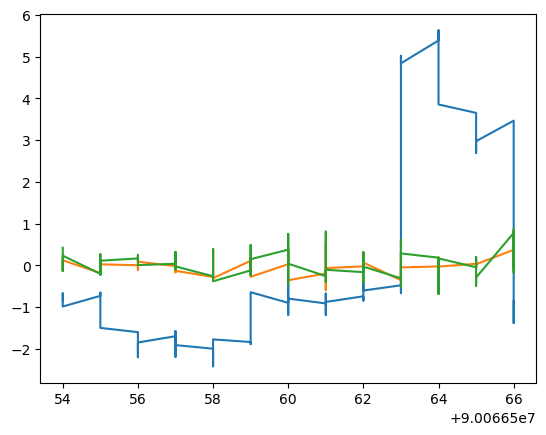

In [99]:
# Plot the accelerations.
plt.plot(df['sampleTimeStamp.seconds'], df['accel_x'])
plt.plot(df['sampleTimeStamp.seconds'], df['accel_y'])
plt.plot(df['sampleTimeStamp.seconds'], df['accel_z'])
plt.show()

The plots look unexpectedly _jumpy_. The reason behind it is that we chose the colum `sampleTimeStamp.seconds` that is complemented by column `sampleTimeStamp.microseconds` to reflect the actual sampling rate. Hence, we combine both columns into one new column that we name `timestamp` to reflect the correct resolution of time.

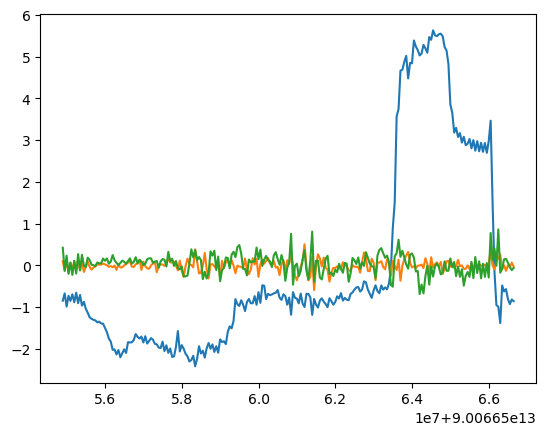

In [100]:
# Plot the accelerations but this time using the correct resolution of time.
df['timestamp'] = df['sampleTimeStamp.seconds'] * 1000000 + df['sampleTimeStamp.microseconds']
plt.plot(df['timestamp'], df['accel_x'])
plt.plot(df['timestamp'], df['accel_y'])
plt.plot(df['timestamp'], df['accel_z'])
plt.show()

We are interested to identify when the vehicle was starting the emergency maneuver. Intuitively, this happens when the longitudinal acceleration is starting to peak. First, we find this point in time with a naïve approach by looking at the data sample by sample and once it is exceeding a certain threshold, we assume to have found the moment when the maneuver started.

In [101]:
threshold = 5.4
times_for_maneuver = []
for _, row in df.iterrows():
    # The following line has been commented out for readability purposes.
    #print( str(row['timestamp']) + ": "+ str(row['accel_x']) )
    if row['accel_x'] > threshold:
        print( "Maneuver at " + str(row['timestamp']) )
        times_for_maneuver.append(row['timestamp'])
print( "Length of maneuver: " + str(len(times_for_maneuver)) )

Maneuver at 90066564446148.0
Maneuver at 90066564495895.0
Maneuver at 90066564545893.0
Maneuver at 90066564595904.0
Maneuver at 90066564645871.0
Maneuver at 90066564695876.0
Maneuver at 90066564745892.0
Maneuver at 90066564795926.0
Length of maneuver: 8


For emergency braking, the maneuver can be easily identified by sorting all data by longitudinal accelerations as key pointing to the respective timepoints. However, this approach would only work as long as we only use one dimension from a multi-dimensional dataspace. Once we use more dimensions, we need a different strategy and here, the concept of space-filling curves is useful.

Using our previous approach, the maneuver was found as expected but for an expensive computational operation: `O(n)`. In particular, this is a disadvantage in case the problem size grows, ie., when more data would need to be processed. In addition, when we fine-tune the threshold, we would have to re-run the detector again for the same computational effort. So, we are interested to find a better approach that is ideally agnostic from the amount of data but is similar to our intuitive approach when we "just looked" at the peaks of the data.

The problem, though, is that we want to analyze time-series data, which can be arbitrarily large and that we may need to analyze multiple dimensions simultaneously. Now, space-filling curves come into play when we try a better approach to spot interesting events in time-series data. When analyzing time-series data using the ordering criterion time for queries, data look-ups are simple and fast for queries such as: "How did the data sample look like at time X?" or "How many data samples do we have between time points X and Y?".

Yet, such queries are usually less relevant for data analysts who are interested in certain properties or conditions taking place in the multi-dimensional data space, where, however, the look-up is computationally expensive for growing amounts of data. Hence, we are interested in a computationally efficient approach to process multi-dimensional data samples.

Now, we are exploiting space-filling curves for this purpose to encode multi-dimensional data samples in a way that allows us to conduct a quick look-up of _relevant_ data.

Firstly, we define conversion functions to map two-dimensional data like longitudinal and lateral accelerations into single-dimensional Morton values including the corresponding inverse operations:

In [102]:
def calculateMortonFromXYAccelerationFloats(x, y):
    _x = np.float32(x)
    _y = np.float32(y)
    # Cap floating point numbers to six decimal places.
    x_int = np.uint32( np.round( (_x + np.float32(10.0) ), 6 ) * np.uint32(100) )
    y_int = np.uint32( np.round( (_y + np.float32(10.0) ), 6 ) * np.uint32(100) )
    value = mortonEncode2D(x_int, y_int)
    return value

def calculateXYAccelerationFloatsFromMorton(a):
    pair = mortonDecode2D(a)
    _x = np.float32(pair[0] / np.float32(100.0) - np.float32(10.0))
    _y = np.float32(pair[1] / np.float32(100.0) - np.float32(10.0))
    return (_x, _y)

As we noticed that the emergency braking manifests clearly along the longitudinal acceleration, we define the consant `y = 0`:

In [103]:
counter = 0
y = 0
for _, row in df.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], y)
    print( str(row['timestamp']) + ": (" + str(row['accel_x']) + ",0) --> " + str(morton) )
    counter = counter + 1
print( "Processed " + str(counter) + " rows." )

90066554895574.0: (-0.8444923,0) --> 1042821
90066554945599.0: (-0.668745,0) --> 1043601
90066554995606.0: (-0.9835685,0) --> 1042577
90066555045596.0: (-0.7277404,0) --> 1042901
90066555095560.0: (-0.8486654,0) --> 1042821
90066555145602.0: (-0.6911783,0) --> 1043588
90066555195612.0: (-0.8817868,0) --> 1042645
90066555245543.0: (-0.6518968,0) --> 1043604
90066555295612.0: (-0.9034342,0) --> 1042641
90066555345551.0: (-0.7057287,0) --> 1043585
90066555395565.0: (-0.9611551,0) --> 1042581
90066555445902.0: (-0.8725309,0) --> 1042816
90066555495627.0: (-1.036656,0) --> 1042560
90066555545615.0: (-1.130846,0) --> 1031572
90066555595574.0: (-1.241084,0) --> 1031365
90066555645582.0: (-1.276467,0) --> 1031360
90066555695577.0: (-1.300929,0) --> 1031313
90066555745609.0: (-1.315992,0) --> 1031312
90066555795654.0: (-1.361566,0) --> 1030613
90066555845572.0: (-1.345597,0) --> 1031297
90066555895608.0: (-1.38821,0) --> 1030609
90066555945581.0: (-1.393638,0) --> 1030608
90066555995630.0: (-1.

Simply calcuating the Morton codes for the given tuples for floating point values is pointless unless we store the data in a new tabluar representation. In the following, we compute the Morton codes for the accelerations in X/Y directions to obtain a single-dimensional representation of the data values.

In [104]:
lst = []
y = 0
for _, row in df.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], y)
    lst.append({'morton': morton, 'timestamp': row['timestamp']})

df2 = pd.DataFrame(lst, columns=['morton', 'timestamp'])
print( df2 )

      morton     timestamp
0    1042821  9.006655e+13
1    1043601  9.006655e+13
2    1042577  9.006655e+13
3    1042901  9.006656e+13
4    1042821  9.006656e+13
..       ...           ...
231  1043669  9.006657e+13
232  1042837  9.006657e+13
233  1042629  9.006657e+13
234  1042836  9.006657e+13
235  1042820  9.006657e+13

[236 rows x 2 columns]


Let's look at the data how it is stored in the new table. As we deal with single-dimensional data, we use a stripe plot for clarity.

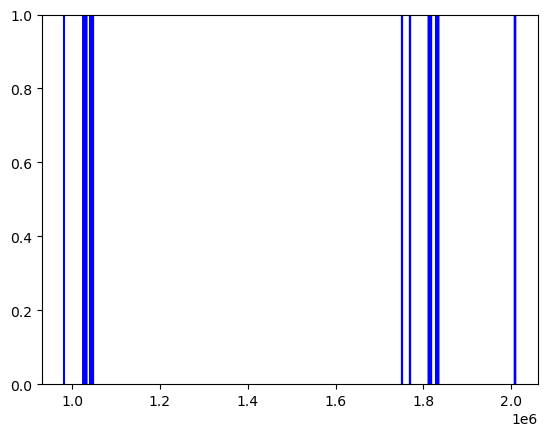

In [105]:
from matplotlib import pyplot as plt

plt.figure()
data = df2['morton']
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors='b', lineoffsets=0.5)
plt.show()

So, the question is how to interpret the new data that we generated using the Morton computations. Let's iterate over all new rows to split the tuples `(Morton value, timestamp)` such that those Morton values, which do not belong to the time points when the vehicle exhibited an emergency braking maneuver (that we calculated already before using a computationally expensive approach), are in one group (`group_A`) and the others in another group (`group_B`). Then, we can color both groups differently for clarity in the plot. 

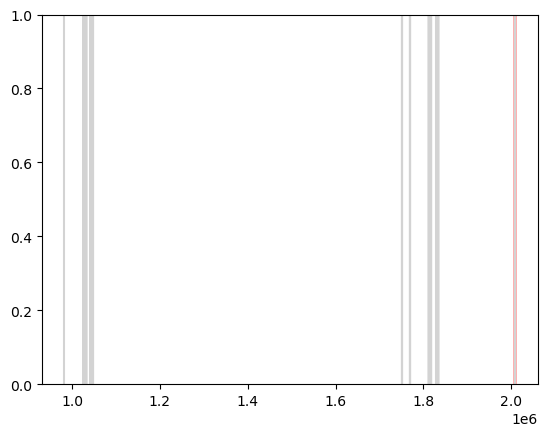

In [106]:
group_A = []
group_B = []
for _, row in df2.iterrows():
    morton = row['morton']
    timestamp = row['timestamp']
    if timestamp in times_for_maneuver:
        group_A.append(morton)
    else:
        group_B.append(morton)

plt.figure()
data = [group_A, group_B]
data_colors = ['red', 'lightgray']
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])
plt.show()

It seems that the emergency braking maneuver of interest is gathering in a certain spectrum of our single-dimensional representation; let's zoom in:

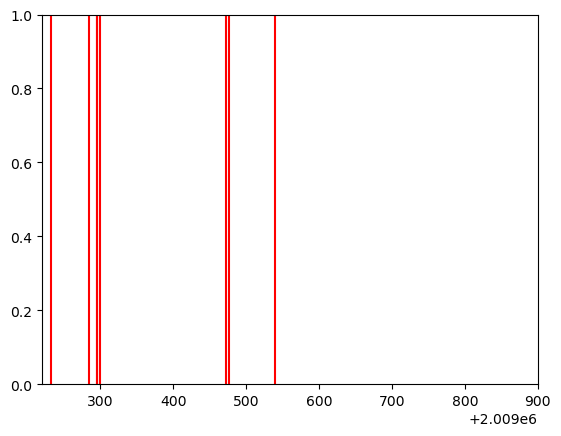

In [107]:
group_A = []
group_B = []
for _, row in df2.iterrows():
    morton = row['morton']
    timestamp = row['timestamp']
    if timestamp in times_for_maneuver:
        group_A.append(morton)
    else:
        group_B.append(morton)

plt.figure()
data = [group_A, group_B]
data_colors = ['red', 'lightgray']
# Zoom in around 2.009e6.
plt.xlim( (2.00922e6,2.0099e6) )
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])
plt.show()

Actually, we can exploit this accumulation when we sort our tabular representation of tuples `(Morton value, timestamp)` by increasing Morton values:

In [108]:
df2 = df2.sort_values(by=['morton'])
print( df2 )

      morton     timestamp
69    982420  9.006656e+13
66   1026180  9.006656e+13
67   1026193  9.006656e+13
70   1026240  9.006656e+13
74   1026245  9.006656e+13
..       ...           ...
195  2009296  9.006656e+13
194  2009300  9.006656e+13
196  2009473  9.006656e+13
197  2009476  9.006656e+13
193  2009540  9.006656e+13

[236 rows x 2 columns]


Now, we can exploit our knowledge that the emergency braking maneuver accumulates around the Morton values between 2.00922e6 and 2.0099e6 and hence, we can simply filter by keys within this range:

In [109]:
dict_of_morton_to_timestamps = dict(zip(df2.morton, df2.timestamp))
matches = list(filter( lambda k: k > 2.00922e6 and k < 2.0099e6, dict_of_morton_to_timestamps.keys()) )
print( "Length of maneuver: " + str(len(matches)) + ", entries: " + str(matches))

Length of maneuver: 7, entries: [2009232, 2009284, 2009296, 2009300, 2009473, 2009476, 2009540]


Please note that we have 7 entries even though the length of the maneuver was identified as 8 using the brute-force approach before. The reason is that the Morton value `2009232` has been assigned twice but is only listed once in the list.

In [111]:
from collections import defaultdict
from itertools import chain

# The standard dictionary in Python does not allow duplicated keys and hence, we use the defaultdict based on list.
defaultdict_of_morton_to_timestamps = defaultdict(list)
for k, v in zip(df2.morton, df2.timestamp):
    defaultdict_of_morton_to_timestamps[k].append(v)

# Filter the keys between the lower and upper limit.
matches = list(filter( lambda k: k > 2.00922e6 and k < 2.0099e6, defaultdict_of_morton_to_timestamps.keys()) )

# Finally, we need to "flatten" the matches to reduce the set of duplicated values for some keys:
_timepoints = []
for e in matches:
    _timepoints.append(defaultdict_of_morton_to_timestamps[e])
timepoints_for_maneuver_morton_setting_y_to_0 = sorted(list(chain.from_iterable(_timepoints)))
print( "Length of maneuver: " + str(len(timepoints_for_maneuver_morton_setting_y_to_0)) + ", entries: " + str(timepoints_for_maneuver_morton_setting_y_to_0))

Length of maneuver: 8, entries: [90066564446148.0, 90066564495895.0, 90066564545893.0, 90066564595904.0, 90066564645871.0, 90066564695876.0, 90066564745892.0, 90066564795926.0]


Now, the number of values matches the ones from the brute-force approach. Let's check whether the lists are identical:

In [113]:
print( str(times_for_maneuver) )
print( str(timepoints_for_maneuver_morton_y_is_0) )

if times_for_maneuver == timepoints_for_maneuver_morton_setting_y_to_0:
    print("The lists are identical.")
else:
    print("The lists are not identical.")

[90066564446148.0, 90066564495895.0, 90066564545893.0, 90066564595904.0, 90066564645871.0, 90066564695876.0, 90066564745892.0, 90066564795926.0]
[90066564446148.0, 90066564495895.0, 90066564545893.0, 90066564595904.0, 90066564645871.0, 90066564695876.0, 90066564745892.0, 90066564795926.0]
The lists are identical.


So far, we have demonstrated how to use Morton values for a single dimension while using a constant for the other dimension, ie., `y = 0`.

Now, we use both, the real lateral and longitudinal accelerations.

In [114]:
counter = 0
for _, row in df.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], row['accel_y'])
    print( str(row['timestamp']) + ": (" + str(row['accel_x']) + "," + str(row['accel_y']) + ") --> " + str(morton) )
    counter = counter + 1
print( "Processed " + str(counter) + " rows." )

90066554895574.0: (-0.8444923,0.1022399) --> 1043213
90066554945599.0: (-0.668745,-0.1258405) --> 1042075
90066554995606.0: (-0.9835685,0.1231426) --> 1042993
90066555045596.0: (-0.7277404,-0.1817489) --> 1041271
90066555095560.0: (-0.8486654,0.07348659) --> 1042863
90066555145602.0: (-0.6911783,-0.121459) --> 1042062
90066555195612.0: (-0.8817868,0.1063761) --> 1043037
90066555245543.0: (-0.6518968,-0.1288908) --> 1042078
90066555295612.0: (-0.9034342,0.1257638) --> 1043057
90066555345551.0: (-0.7057287,-0.115673) --> 1042081
90066555395565.0: (-0.9611551,0.1024586) --> 1042973
90066555445902.0: (-0.8725309,-0.1549342) --> 1041280
90066555495627.0: (-1.036656,-0.03717339) --> 1042464
90066555545615.0: (-1.130846,0.09871539) --> 1031958
90066555595574.0: (-1.241084,-0.03325236) --> 1031269
90066555645582.0: (-1.276467,-0.1026151) --> 1029858
90066555695577.0: (-1.300929,-0.05037307) --> 1031193
90066555745609.0: (-1.315992,-0.0225835) --> 1031218
90066555795654.0: (-1.361566,0.02452186

Let's create a tabular representation again:

In [115]:
lst = []
for _, row in df.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], row['accel_y'])
    lst.append({'morton': morton, 'timestamp': row['timestamp']})

df2 = pd.DataFrame(lst, columns=['morton', 'timestamp'])
print( df2 )

      morton     timestamp
0    1043213  9.006655e+13
1    1042075  9.006655e+13
2    1042993  9.006655e+13
3    1041271  9.006656e+13
4    1042863  9.006656e+13
..       ...           ...
231  1042143  9.006657e+13
232  1042837  9.006657e+13
233  1042511  9.006657e+13
234  1042876  9.006657e+13
235  1042724  9.006657e+13

[236 rows x 2 columns]


Let's look at the data how it is stored in the new table. As we deal with single-dimensional data, we use a stripe plot for clarity.

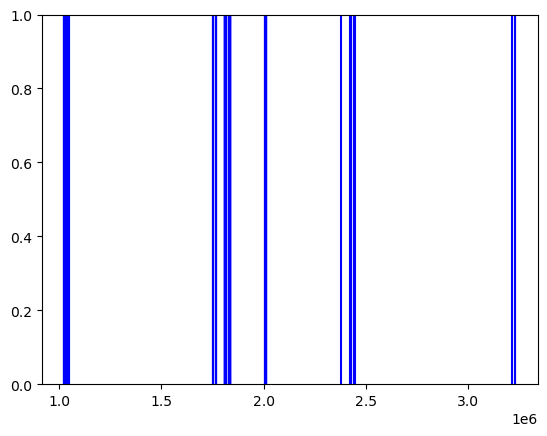

In [116]:
from matplotlib import pyplot as plt

plt.figure()
data = df2['morton']
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors='b', lineoffsets=0.5)
plt.show()

So, the question is how to interpret the new data that we generated using the Morton computations. Let's iterate over all new rows to split the tuples `(Morton value, timestamp)` such that those Morton values, which do not belong to the time points when the vehicle exhibited an emergency braking maneuver (that we calculated already before using a computationally expensive approach), are in one group (`group_A`) and the others in another group (`group_B`). Then, we can color both groups differently for clarity in the plot. 

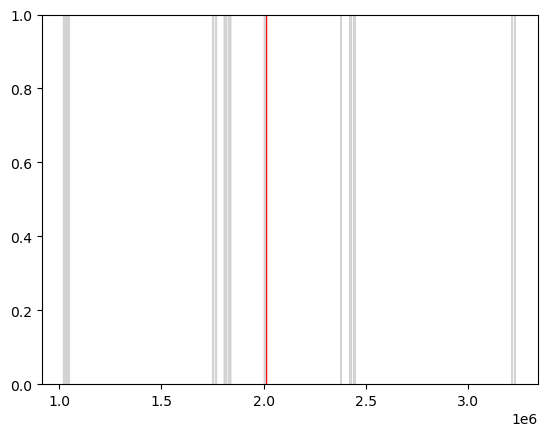

In [117]:
group_A = []
group_B = []
for _, row in df2.iterrows():
    morton = row['morton']
    timestamp = row['timestamp']
    if timestamp in times_for_maneuver:
        group_A.append(morton)
    else:
        group_B.append(morton)

plt.figure()
data = [group_A, group_B]
data_colors = ['red', 'lightgray']
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])
plt.show()

It seems that the emergency braking maneuver of interest is gathering in a certain spectrum of our single-dimensional representation; and actually, we can exploit this accumulation when we sort our tabular representation of tuples `(Morton value, timestamp)` by increasing Morton values:

In [118]:
df2 = df2.sort_values(by=['morton'])
print( df2 )

      morton     timestamp
72   1024825  9.006656e+13
28   1024935  9.006656e+13
63   1025184  9.006656e+13
76   1025236  9.006656e+13
82   1025430  9.006656e+13
..       ...           ...
126  2441880  9.006656e+13
157  2445358  9.006656e+13
223  3215526  9.006657e+13
180  3228821  9.006656e+13
179  3232081  9.006656e+13

[236 rows x 2 columns]


Now, we can exploit our knowledge from before that the emergency braking maneuver accumulates around the Morton values between 2.00922e6 and 2.0099e6 and hence, we can simply filter by keys within this range:

In [119]:
dict_of_morton_to_timestamps = dict(zip(df2.morton, df2.timestamp))
matches = list(filter( lambda k: k > 2.00922e6 and k < 2.0099e6, dict_of_morton_to_timestamps.keys()) )
print( "Length of maneuver: " + str(len(matches)) + ", entries: " + str(matches))

Length of maneuver: 6, entries: [2009308, 2009338, 2009379, 2009422, 2009754, 2009860]


Using the same lower and upper limits for the range to match the keys as for the previous case when we used a constant for y does not yield the same results. This is understandable as the Morton values differ because their are computed based on two dimensions and hence, we need to relax the range filter. Therefore, we use a larger area: 1.9e6 up to 2.1e6 as the emergency braking seems to cluster around 2.0e6:

In [120]:
dict_of_morton_to_timestamps = dict(zip(df2.morton, df2.timestamp))
matches = list(filter( lambda k: k > 1.9e6 and k < 2.1e6, dict_of_morton_to_timestamps.keys()) )
print( "Length of maneuver: " + str(len(matches)) + ", entries: " + str(matches))

Length of maneuver: 9, entries: [2007642, 2007660, 2009126, 2009308, 2009338, 2009379, 2009422, 2009754, 2009860]


Now, we received those Morton codes that are between the specified minimum and maximum values but the list is longer than the one we got based on the brute-force detector. Let's decode the Morton values to compare the encoded accelerations:

In [121]:
for morton in matches:
    acc = calculateXYAccelerationFloatsFromMorton(morton)
    print( str(morton) + " --> " + "(" + str(acc[0]) + "," + str(acc[1]) + ")")

2007642 --> (5.48,-0.21)
2007660 --> (5.46,-0.18)
2009126 --> (5.38,-0.03)
2009308 --> (5.5,0.02)
2009338 --> (5.48,0.07)
2009379 --> (5.53,-0.03)
2009422 --> (5.62,-0.05)
2009754 --> (5.4,0.19)
2009860 --> (5.54,0.08)


As we can see, the third item maps a Morton value to the tuple `(5.38, -0.03)`, which is below the threshold of `5.4` that we defined above. Next, we match the Morton values that act as keys in our dictionary `dict_of_morton_to_timestamps` with the list of `times_for_maneuver` from the brute-force approach to validate that we actually found the correct elements for the one with the correct accelerations:

In [122]:
times_for_maneuver_morton = []
for morton in matches:
    acc = calculateXYAccelerationFloatsFromMorton(morton)
    if acc[0] > threshold:
        times_for_maneuver_morton.append(dict_of_morton_to_timestamps[morton])
times_for_maneuver.sort()
times_for_maneuver_morton.sort()

print( str(times_for_maneuver) )
print( str(times_for_maneuver_morton) )

if times_for_maneuver == times_for_maneuver_morton:
    print("The lists are identical.")
else:
    print("The lists are not identical.")

[90066564446148.0, 90066564495895.0, 90066564545893.0, 90066564595904.0, 90066564645871.0, 90066564695876.0, 90066564745892.0, 90066564795926.0]
[90066564446148.0, 90066564495895.0, 90066564545893.0, 90066564595904.0, 90066564645871.0, 90066564695876.0, 90066564745892.0, 90066564795926.0]
The lists are identical.


Let's compare the computational performance for both event detectors, starting with the previous one that is operating on the multi-dimensional data space (the print statements have been disabled):

In [123]:
%%timeit
threshold = 5.4
times_for_maneuver = []
for _, row in df.iterrows():
    #print( str(row['timestamp']) + ": "+ str(row['accel_x']) )
    if row['accel_x'] > threshold:
        #print( "Maneuver at " + str(row['timestamp']) )
        times_for_maneuver.append(row['timestamp'])

3.21 ms ± 19 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now, let's time the key ranges look-up (the print statement has been disabled):

In [124]:
%%timeit
my_dict = dict(zip(df2.morton, df2.timestamp))
l = list(filter( lambda k: k > 1.9e6 and k < 2.1e6, my_dict.keys()))
#print(str(l))

59.7 µs ± 198 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The dict-based key look-up using a range filter is much faster than the `O(n)` event look-up. Let's only sort out the final question why the `O(n)`, brute-force look-up is returning 8 hits when the dict-based look-up is returning 9 hits. Therefore, we transform the matching Morton values back into their corresponding accelerations for X/Y dimensions:

Finally, we need to check whether our key-based range look-up does not react when there is no emergency braking maneuver, ie., no peak in the data. Therefore, we simpy replace `accel_x` with `accel_z` and repeat the analysis.

      morton     timestamp
0    1747724  9.006655e+13
1    1045454  9.006655e+13
2    1048437  9.006655e+13
3    1045287  9.006656e+13
4    1047806  9.006656e+13
..       ...           ...
231  1046431  9.006657e+13
232  1047764  9.006657e+13
233  1047578  9.006657e+13
234  1047032  9.006657e+13
235  1047588  9.006657e+13

[236 rows x 2 columns]


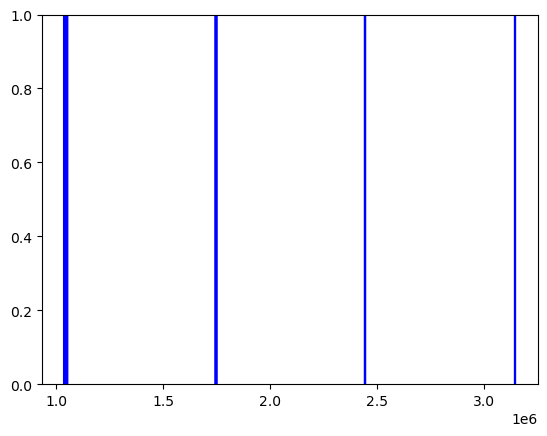

In [125]:
lst = []
for _, row in df.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_z'], row['accel_y'])
    lst.append({'morton': morton, 'timestamp': row['timestamp']})

df3 = pd.DataFrame(lst, columns=['morton', 'timestamp'])
print( df3 )

plt.figure()
data = df3['morton']
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors='b', lineoffsets=0.5)
plt.show()

And indeed, the stripes around 2.0e6 disappeared as expected.